In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fmdtools.faultsim as fs
import fmdtools.resultdisp as rd
import quadpy
from IPython.display import HTML

In [2]:
from fmdtools.modeldef import FxnBlock
from fmdtools.modeldef import Model

### Setting Node Positions

In [17]:
class Drone(Model):
    def __init__(self, params={}):
        super().__init__()
        self.params=params
        #add flows to the model
        self.add_flow('Force_ST', {})
        self.add_flow('Force_Lin', {})
        self.add_flow('Force_GR' , {})
        self.add_flow('Force_LG', {})
        self.add_flow('EE_1', {})
        self.add_flow('EEmot', {})
        self.add_flow('EEctl', {})
        self.add_flow('Ctl1', {})
        self.add_flow('DOFs', {})
        self.add_flow('Env1', {})
        # custom flows
        self.add_flow('Dir1', {})
        #add functions to the model
        flows=['EEctl', 'Force_ST']
        self.add_fxn('StoreEE',['EE_1', 'Force_ST'])
        self.add_fxn('DistEE', ['EE_1','EEmot','EEctl', 'Force_ST'])
        self.add_fxn('AffectDOF',['EEmot','Ctl1','DOFs','Force_Lin'])
        self.add_fxn('CtlDOF', ['EEctl', 'Dir1', 'Ctl1', 'DOFs', 'Force_ST'])
        self.add_fxn('Planpath', ['EEctl', 'Env1','Dir1', 'Force_ST'])
        self.add_fxn('Trajectory', ['Env1','DOFs','Dir1', 'Force_GR'] )
        self.add_fxn('EngageLand',['Force_GR', 'Force_LG'])
        self.add_fxn('HoldPayload',['Force_LG', 'Force_Lin', 'Force_ST'])
        self.add_fxn('ViewEnv', ['Env1'])
        
        self.construct_graph()
        #self.construct_graph(graph_pos = {'StoreEE': [0.13322414342899602, 0.21477632506511113],
 #'DistEE': [0.5896210930551233, -0.08591779042202319],
 #'AffectDOF': [0.4267774855331683, 0.4401963508136246],
 #'CtlDOF': [-0.5, 0.8660253882408142],
 #'Planpath': [-0.9396925568580627, 0.3420202136039734],
 #'Trajectory': [-0.7402574040187169, -0.6565140488613741],
 #'EngageLand': [0.02927033251370781, -0.3981198969531473],
 #'HoldPayload': [-0.5397160219633146, 0.5493088305815919],
 #'ViewEnv': [0.7660443782806396, -0.642787754535675]})

In [18]:
mdl = Drone()

As shown below, it can be difficult to make sense of a model structure using the default shell graph layout. We might instead want to see something that more closely approximates a flow chart of the system.

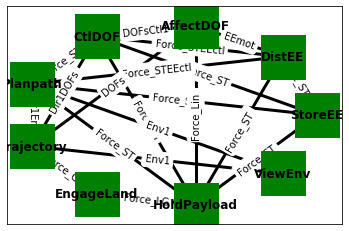

In [24]:
rd.graph.show(mdl.graph)

To set node positions, we can use ``rd.graph.set_pos()``, which lets one drag the nodes to their desired locations. If a model is sent to ``set_pos``, it will set those locations in the model going forward, though it is good practice to save node locations when one is done in the script or the model class file (they can be used as inputs to ``construct_graph()``.

In [20]:
%matplotlib qt
pos = rd.graph.set_pos(mdl)
pos

{'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

In [25]:
graph_pos = {'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

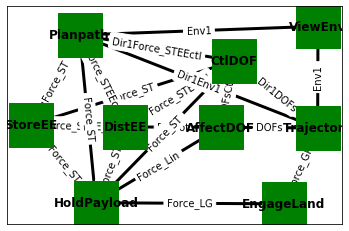

In [26]:
%matplotlib inline
rd.graph.show(mdl)

We can use the same process to arrange the bipartite graph:

In [27]:
%matplotlib qt
pos = rd.graph.set_pos(mdl, gtype='bipartite')
pos

In [28]:
pos

{'StoreEE': [-1.067135163123663, 0.32466987344741055],
 'DistEE': [-0.617149602161968, 0.3165981670924663],
 'AffectDOF': [0.11827439153655106, 0.10792528450121897],
 'CtlDOF': [-0.2636856982162134, 0.42422600969836144],
 'Planpath': [-0.9347151173753852, 0.6943421719257798],
 'Trajectory': [0.6180477286739998, 0.32930706399226856],
 'EngageLand': [0.0015917696269229786, -0.2399760932810826],
 'HoldPayload': [-0.8833099612826893, -0.247201580673997],
 'ViewEnv': [0.5725955705698363, 0.6901513410348765],
 'Force_ST': [-0.8925771348524384, -0.025638904424547027],
 'Force_Lin': [-0.5530952425102891, -0.10380834289626095],
 'Force_GR': [0.568921162299461, -0.22991830334765573],
 'Force_LG': [-0.37244114591548894, -0.2355298479531287],
 'EE_1': [-0.809433489993954, 0.319191761486317],
 'EEmot': [-0.33469985340998853, 0.1307636433702345],
 'EEctl': [-0.48751243650229525, 0.4852032717825657],
 'Ctl1': [-0.06913038312848868, 0.2445174568603189],
 'DOFs': [0.2606664304933561, 0.3243482171363975

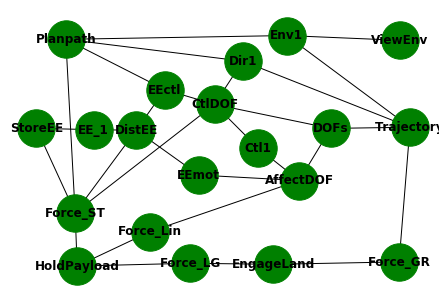

In [38]:
%matplotlib inline
rd.graph.show(mdl, gtype='bipartite', pos = bipartite_pos, scale=2)

As shown, in a large model, the Bipartite graph is often easier to arrange. Since the model will be redefined several times going forward, we will use these positions to keep a consistent layout:

In [39]:
bipartite_pos = {'StoreEE': [-1.067135163123663, 0.32466987344741055],
 'DistEE': [-0.617149602161968, 0.3165981670924663],
 'AffectDOF': [0.11827439153655106, 0.10792528450121897],
 'CtlDOF': [-0.2636856982162134, 0.42422600969836144],
 'Planpath': [-0.9347151173753852, 0.6943421719257798],
 'Trajectory': [0.6180477286739998, 0.32930706399226856],
 'EngageLand': [0.0015917696269229786, -0.2399760932810826],
 'HoldPayload': [-0.8833099612826893, -0.247201580673997],
 'ViewEnv': [0.5725955705698363, 0.6901513410348765],
 'Force_ST': [-0.8925771348524384, -0.025638904424547027],
 'Force_Lin': [-0.5530952425102891, -0.10380834289626095],
 'Force_GR': [0.568921162299461, -0.22991830334765573],
 'Force_LG': [-0.37244114591548894, -0.2355298479531287],
 'EE_1': [-0.809433489993954, 0.319191761486317],
 'EEmot': [-0.33469985340998853, 0.1307636433702345],
 'EEctl': [-0.48751243650229525, 0.4852032717825657],
 'Ctl1': [-0.06913038312848868, 0.2445174568603189],
 'DOFs': [0.2606664304933561, 0.3243482171363975],
 'Env1': [0.06157634305459603, 0.7099922980251693],
 'Dir1': [-0.13617863906968142, 0.6037252153639261]}

graph_pos = {'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

### Network Model

### Static Model

### Dynamic Model

### Hierarchical Model